In [1]:
import os
os.environ["SSL_CERT_FILE"] = "/mnt/d/Travel Assistant/Musafir/Fortinet_CA_SSL(15).cer"
os.environ["REQUESTS_CA_BUNDLE"] = "/mnt/d/Travel Assistant/Musafir/Fortinet_CA_SSL(15).cer"

In [2]:
import requests
import json
from bs4 import BeautifulSoup


In [3]:
def fetch_wikivoyage_sections(page: str, user_agent="MyWikiVoyageClient/1.0 (contact: your-email@example.com)"):
    api_url = "https://en.wikivoyage.org/w/api.php"
    headers = {"User-Agent": user_agent}

    # Step 1: Get metadata about all sections (top + sub)
    params = {
        "action": "parse",
        "page": page,
        "format": "json",
        "prop": "sections"
    }
    res = requests.get(api_url, params=params, headers=headers).json()
    sections_meta = res["parse"]["sections"]

    wanted = {"districts", "see", "buy", "eat", "drink", "sleep", "stay safe"}
    result = {}

    # Helper: clean HTML → paragraphs, list items, tables
    def html_to_paragraphs(html: str):
        soup = BeautifulSoup(html, "html.parser")
        paragraphs = []

        for p in soup.find_all("p"):
            text = p.get_text(" ", strip=True)
            if text:
                paragraphs.append(text)

        for li in soup.find_all("li"):
            text = li.get_text(" ", strip=True)
            if text:
                paragraphs.append(text)

        for td in soup.find_all("td"):
            text = td.get_text(" ", strip=True)
            if text:
                paragraphs.append(text)

        return paragraphs

    # Step 2: Grab description (section 0)
    lead_params = {
        "action": "parse",
        "page": page,
        "format": "json",
        "prop": "text",
        "section": 0
    }
    lead = requests.get(api_url, params=lead_params, headers=headers).json()
    lead_html = lead["parse"]["text"]["*"]
    result["description"] = html_to_paragraphs(lead_html)

    # Step 3: Iterate through sections to build nested structure
    for sec in sections_meta:
        title = sec["line"].strip()
        title_lower = title.lower()
        number = sec["number"]
        index = sec["index"]

        if title_lower in wanted and "." not in number:
            sec_params = {
                "action": "parse",
                "page": page,
                "format": "json",
                "prop": "text",
                "section": index
            }
            sec_data = requests.get(api_url, params=sec_params, headers=headers).json()
            html = sec_data["parse"]["text"]["*"]
            result[title] = {"content": html_to_paragraphs(html), "subsections": {}}

        elif "." in number:
            parent_num = number.split(".")[0]
            parent_section = next((s for s in sections_meta if s["number"] == parent_num), None)
            if parent_section and parent_section["line"].strip().lower() in wanted:
                parent_title = parent_section["line"].strip()
                sec_params = {
                    "action": "parse",
                    "page": page,
                    "format": "json",
                    "prop": "text",
                    "section": index
                }
                sec_data = requests.get(api_url, params=sec_params, headers=headers).json()
                html = sec_data["parse"]["text"]["*"]
                if parent_title in result:
                    result[parent_title]["subsections"][title] = html_to_paragraphs(html)

    return result

# === Multiple cities ===
cities = ["London", "Rome", "Seoul", "Cairo"]

for city in cities:
    print(f"📍 Fetching data for {city}...")
    data = fetch_wikivoyage_sections(city)
    # Create the directory structure if it doesn't exist
    os.makedirs("../data/raw_data", exist_ok=True)
    filename = f"../data/raw_data/{city.lower()}_subsections.json"
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)
    print(f"✅ Saved {filename}")


📍 Fetching data for London...
✅ Saved ../data/raw_data/london_subsections.json
📍 Fetching data for Rome...
✅ Saved ../data/raw_data/rome_subsections.json
📍 Fetching data for Seoul...
✅ Saved ../data/raw_data/seoul_subsections.json
📍 Fetching data for Cairo...
✅ Saved ../data/raw_data/cairo_subsections.json


In [4]:
import json
import csv
import glob
import re
import os
import requests


In [5]:
RAW_FOLDER = "../data/raw_data"
PROCESSED_FOLDER = "../data/processed_data"
os.makedirs(PROCESSED_FOLDER, exist_ok=True)


def convert_json_to_csv(json_file, csv_file):
    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Prefer metadata.city if available, else infer from filename
    meta_city = data.get("metadata", {}).get("city")
    if meta_city:
        city = meta_city
    else:
        base = os.path.basename(json_file)
        m = re.match(r'(.+?)_subsections\.json$', base, flags=re.I)
        if m:
            city_raw = m.group(1)
        else:
            city_raw = os.path.splitext(base)[0]
        city = city_raw.replace("_", " ").strip().title()

    rows = []
    # Description rows
    for text in data.get("description", []):
        rows.append([city, "description", "", text])

    # Sections
    for section, sec_data in data.items():
        if section in ("description", "metadata"):
            continue
        if not isinstance(sec_data, dict):
            continue
        # Top-level content
        for txt in sec_data.get("content", []):
            rows.append([city, section, "", txt])
        # Subsections
        for sub, sub_list in sec_data.get("subsections", {}).items():
            for txt in sub_list:
                rows.append([city, section, sub, txt])

    # Write per-file CSV
    with open(csv_file, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["city", "section", "subsection", "text"])
        writer.writerows(rows)

    return rows


# convert all *_subsections.json files and create combined CSV ===
all_rows = []
files = glob.glob(os.path.join(RAW_FOLDER, "*_subsections.json"))
if not files:
    print("No JSON files found in raw_data folder.")
else:
    for jf in files:
        base = os.path.basename(jf).replace(".json", ".csv")
        csv_name = os.path.join(PROCESSED_FOLDER, base)
        print(f"Converting {jf} -> {csv_name} ...")
        rows = convert_json_to_csv(jf, csv_name)
        all_rows.extend(rows)
        print(f"  rows written: {len(rows)}")

    # Write combined CSV
    combined_name = os.path.join(PROCESSED_FOLDER, "all_cities_combined.csv")
    print(f"Writing combined CSV: {combined_name} (total rows: {len(all_rows)})")
    with open(combined_name, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["city", "section", "subsection", "text"])
        writer.writerows(all_rows)

    print("Done. Per-file CSVs plus combined CSV created in processed_data folder.")


Converting ../data/raw_data/cairo_subsections.json -> ../data/processed_data/cairo_subsections.csv ...
  rows written: 109
Converting ../data/raw_data/london_subsections.json -> ../data/processed_data/london_subsections.csv ...
  rows written: 468
Converting ../data/raw_data/rome_subsections.json -> ../data/processed_data/rome_subsections.csv ...
  rows written: 252
Converting ../data/raw_data/seoul_subsections.json -> ../data/processed_data/seoul_subsections.csv ...
  rows written: 71
Writing combined CSV: ../data/processed_data/all_cities_combined.csv (total rows: 900)
Done. Per-file CSVs plus combined CSV created in processed_data folder.


In [6]:
import pandas as pd

In [7]:
df_all = pd.read_csv("../data/processed_data/all_cities_combined.csv")

In [8]:
df_all

,city,section,subsection,text
0,Cairo,description,NaN,Cairo (pronounced KY-roh ; Arabic : القاهرة al...
1,Cairo,description,NaN,"On the Nile river, Cairo is famous for its own..."
2,Cairo,description,NaN,"Though firmly attached to the past, Cairo is a..."
3,Cairo,Districts,NaN,Greater Cairo is vast; with more than 20 milli...
4,Cairo,Districts,NaN,Downtown The modern city centre. Midan Tahrir ...
...,...,...,...,...
895,Seoul,Stay safe,NaN,Do not try to use drones to take pictures in S...
896,Seoul,Stay safe,NaN,"Unfortunately, crimes by American soldiers aga..."
897,Seoul,Stay safe,NaN,Protesting : Large-scale demonstrations agains...
898,Seoul,Stay safe,NaN,Fake monks have been known to operate in Seoul...


In [9]:
df_all

,city,section,subsection,text
0,Cairo,description,NaN,Cairo (pronounced KY-roh ; Arabic : القاهرة al...
1,Cairo,description,NaN,"On the Nile river, Cairo is famous for its own..."
2,Cairo,description,NaN,"Though firmly attached to the past, Cairo is a..."
3,Cairo,Districts,NaN,Greater Cairo is vast; with more than 20 milli...
4,Cairo,Districts,NaN,Downtown The modern city centre. Midan Tahrir ...
...,...,...,...,...
895,Seoul,Stay safe,NaN,Do not try to use drones to take pictures in S...
896,Seoul,Stay safe,NaN,"Unfortunately, crimes by American soldiers aga..."
897,Seoul,Stay safe,NaN,Protesting : Large-scale demonstrations agains...
898,Seoul,Stay safe,NaN,Fake monks have been known to operate in Seoul...


### Check duplication 

In [10]:
# Selecting duplicate rows based on 'text' within each city
df_all["is_duplicate"] = df_all.duplicated(subset=["city", "text"], keep=False)

# show only duplicates
duplicates = df_all[df_all["is_duplicate"]].sort_values(by=["city", "text"])

print("Found duplicates within the same city:", len(duplicates))
print(duplicates.head())
duplicates

Found duplicates within the same city: 705
     city section                 subsection  \
79  Cairo   Drink                        NaN   
89  Cairo   Drink         Fruit juice stalls   
82  Cairo   Drink                        NaN   
87  Cairo   Drink  Traditional coffee houses   
30  Cairo     See                        NaN   

                                                 text  is_duplicate  
79  A health reminder Use extra care if you choose...          True  
89  A health reminder Use extra care if you choose...          True  
82  A social institution When coffee was introduce...          True  
87  A social institution When coffee was introduce...          True  
30  Also, the pyramids of Saqqara and Memphis offe...          True  


,city,section,subsection,text,is_duplicate
79,Cairo,Drink,NaN,A health reminder Use extra care if you choose...,True
89,Cairo,Drink,Fruit juice stalls,A health reminder Use extra care if you choose...,True
82,Cairo,Drink,NaN,A social institution When coffee was introduce...,True
87,Cairo,Drink,Traditional coffee houses,A social institution When coffee was introduce...,True
30,Cairo,See,NaN,"Also, the pyramids of Saqqara and Memphis offe...",True
...,...,...,...,...,...
865,Seoul,See,Notable museums,There are other interesting museums in the cit...,True
845,Seoul,See,NaN,There are several traditional spots in Seoul b...,True
856,Seoul,See,"Palaces, shrines, and walls of Joseon Dynasty ...",There are several traditional spots in Seoul b...,True
847,Seoul,See,NaN,There are several unique parks that were repur...,True


In [11]:
print("Original rows:", len(df_all))

# helper function for groupwise deduplication
def deduplicate_group(group):
    non_null = group[group["subsection"].notna()]
    if len(non_null) > 0:
        return non_null.iloc[[0]]  # keep first with subsection
    else:
        return group.iloc[[0]]  # keep one even if all NaN subsections

# apply per city+text group
df = (
    df_all.groupby(["city", "text"], group_keys=False)
      .apply(deduplicate_group)
      .reset_index(drop=True)
)

print("Deduplicated rows:", len(df))

# save back
df.to_csv("../data/processed_data/all_cities_combined_no_duplication.csv", index=False)


Original rows: 900
Deduplicated rows: 544


/tmp/ipykernel_4638/995457818.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(deduplicate_group)


In [12]:
df

,city,section,subsection,text,is_duplicate
0,Cairo,See,Further afield,29.8 31.233333 1 Dahshur Pyramids . For a cont...,False
1,Cairo,See,NaN,29.8 31.233333 5 Dahshur Pyramids . For a cont...,False
2,Cairo,See,NaN,30.0405 31.2646 2 Al-Azhar Park . A landscaped...,False
3,Cairo,See,NaN,30.0417 31.2483 4 Abdeen Palace . About 1 km e...,False
4,Cairo,See,NaN,30.0475 31.262222 3 Khan El Khalily . Cairo's ...,False
...,...,...,...,...,...
539,Seoul,Districts,NaN,"West ( Gangseo-gu, Yangcheon-gu ) Western area...",False
540,Seoul,See,NaN,While Seoul today is mostly known as a super-m...,False
541,Seoul,Districts,NaN,Yeongdeungpo & Guro (영등포 / 구로) ( Yeongdeungpo-...,False
542,Seoul,Districts,NaN,Yongsan (용산) ( Yongsan-gu ) Yongsan is home to...,False


In [13]:
# drop is_duplicate col 
df = df.drop('is_duplicate', axis=1)

In [14]:
#Add index col
df.insert(0, 'id', df.index)

In [15]:
df

,id,city,section,subsection,text
0,0,Cairo,See,Further afield,29.8 31.233333 1 Dahshur Pyramids . For a cont...
1,1,Cairo,See,NaN,29.8 31.233333 5 Dahshur Pyramids . For a cont...
2,2,Cairo,See,NaN,30.0405 31.2646 2 Al-Azhar Park . A landscaped...
3,3,Cairo,See,NaN,30.0417 31.2483 4 Abdeen Palace . About 1 km e...
4,4,Cairo,See,NaN,30.0475 31.262222 3 Khan El Khalily . Cairo's ...
...,...,...,...,...,...
539,539,Seoul,Districts,NaN,"West ( Gangseo-gu, Yangcheon-gu ) Western area..."
540,540,Seoul,See,NaN,While Seoul today is mostly known as a super-m...
541,541,Seoul,Districts,NaN,Yeongdeungpo & Guro (영등포 / 구로) ( Yeongdeungpo-...
542,542,Seoul,Districts,NaN,Yongsan (용산) ( Yongsan-gu ) Yongsan is home to...


In [16]:
df.to_csv("../data/processed_data/all_cities_combined_clean.csv", index=False)


### Check null values 

In [17]:
# Check for null values and sum them per column
null_counts = df.isnull().sum()
print("Null values per column:")
print(null_counts)

Null values per column:
id              0
city            0
section         0
subsection    199
text            0
dtype: int64


### Visulize the text col

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [19]:
# function to create word clouds using the 250 most frequent words
def create_word_cloud(text, city_name):
    wordcloud = WordCloud(
        width=1400,
        height=700,
        background_color="#F5EFE6",
        max_words=1500,
        min_font_size=10,
    ).generate(text)
    
    plt.figure(figsize=(18, 10), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"The most frequent words in {city_name}", fontsize=20)
    plt.show()
    print("*" * 200)


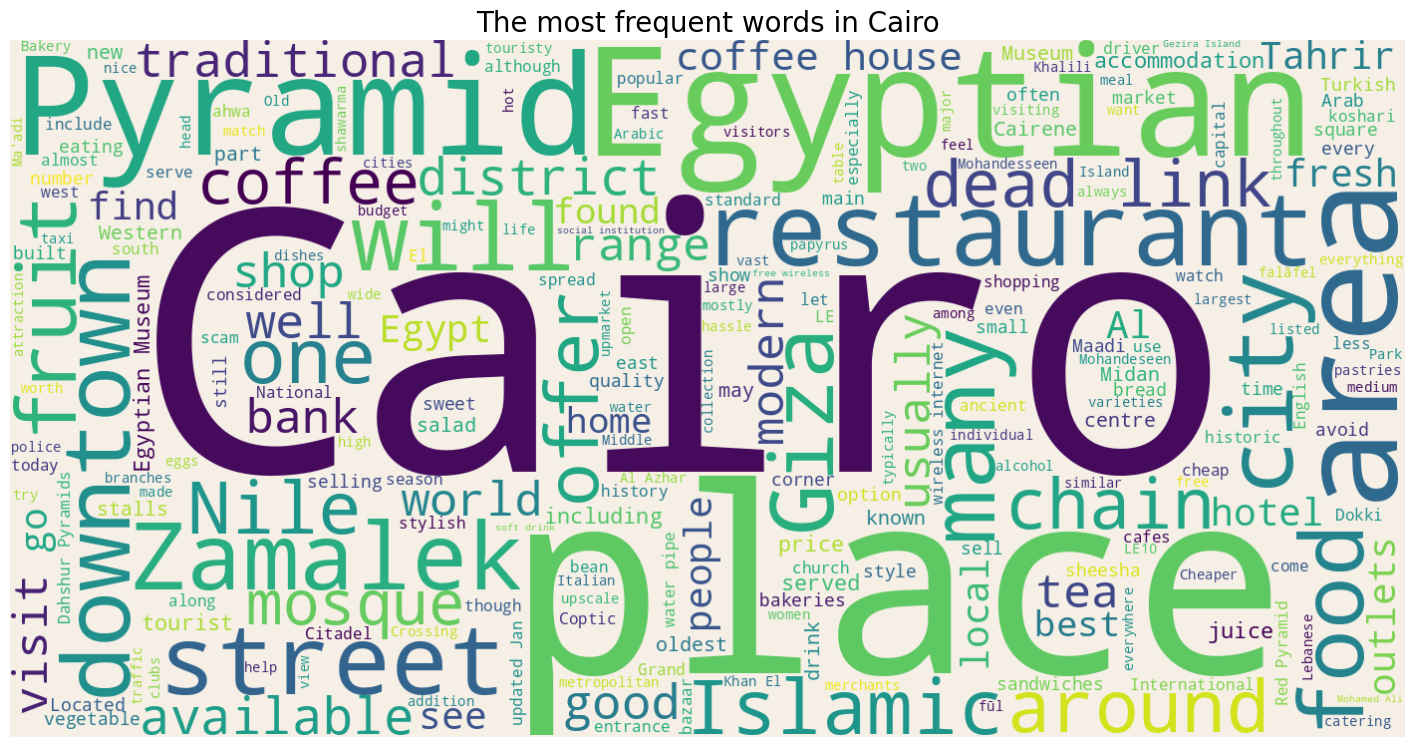

********************************************************************************************************************************************************************************************************


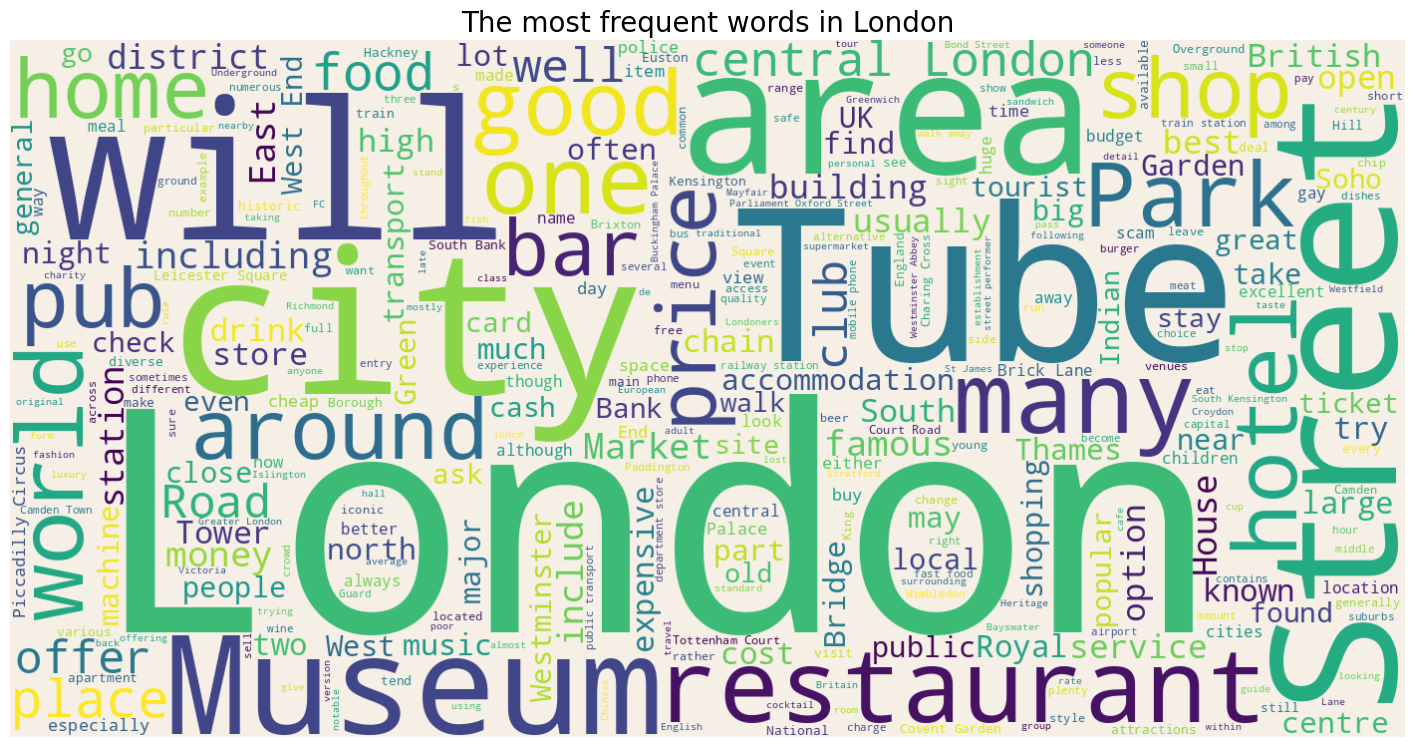

********************************************************************************************************************************************************************************************************


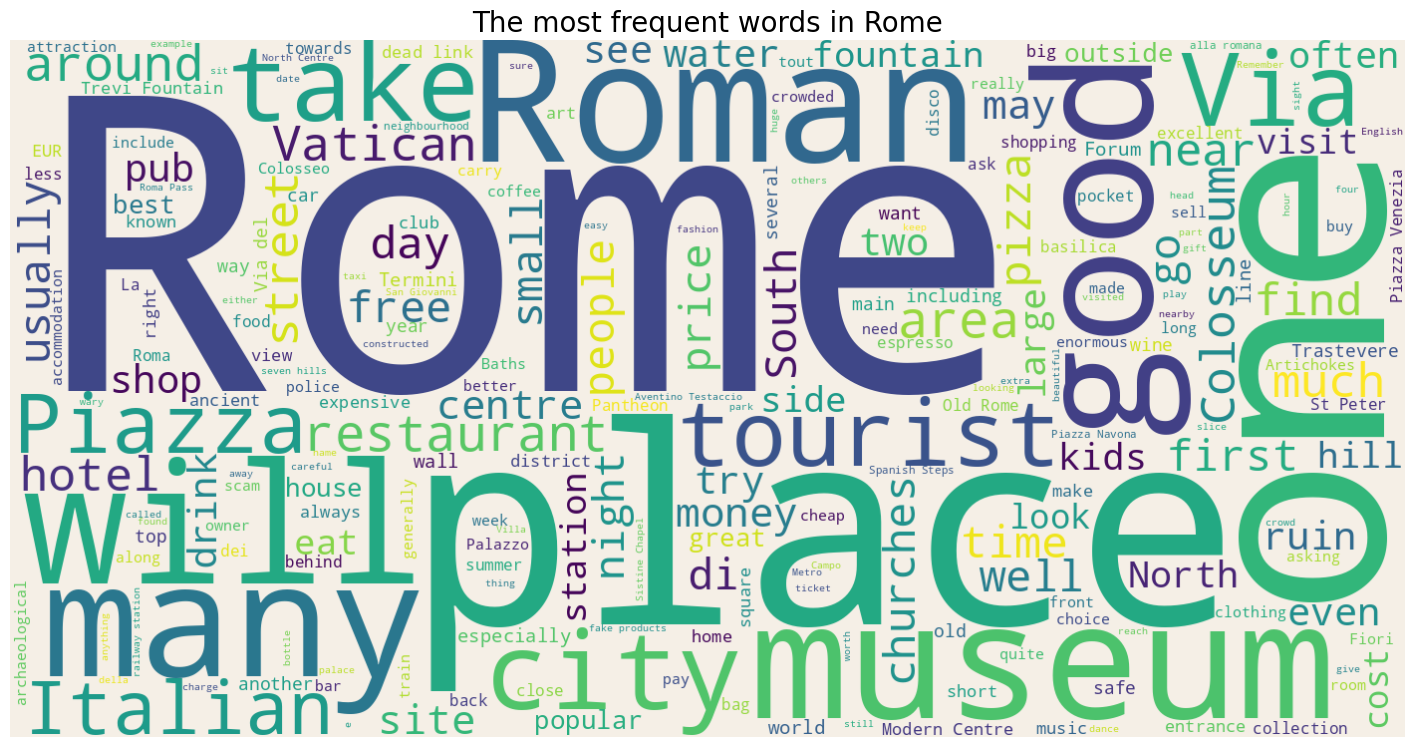

********************************************************************************************************************************************************************************************************


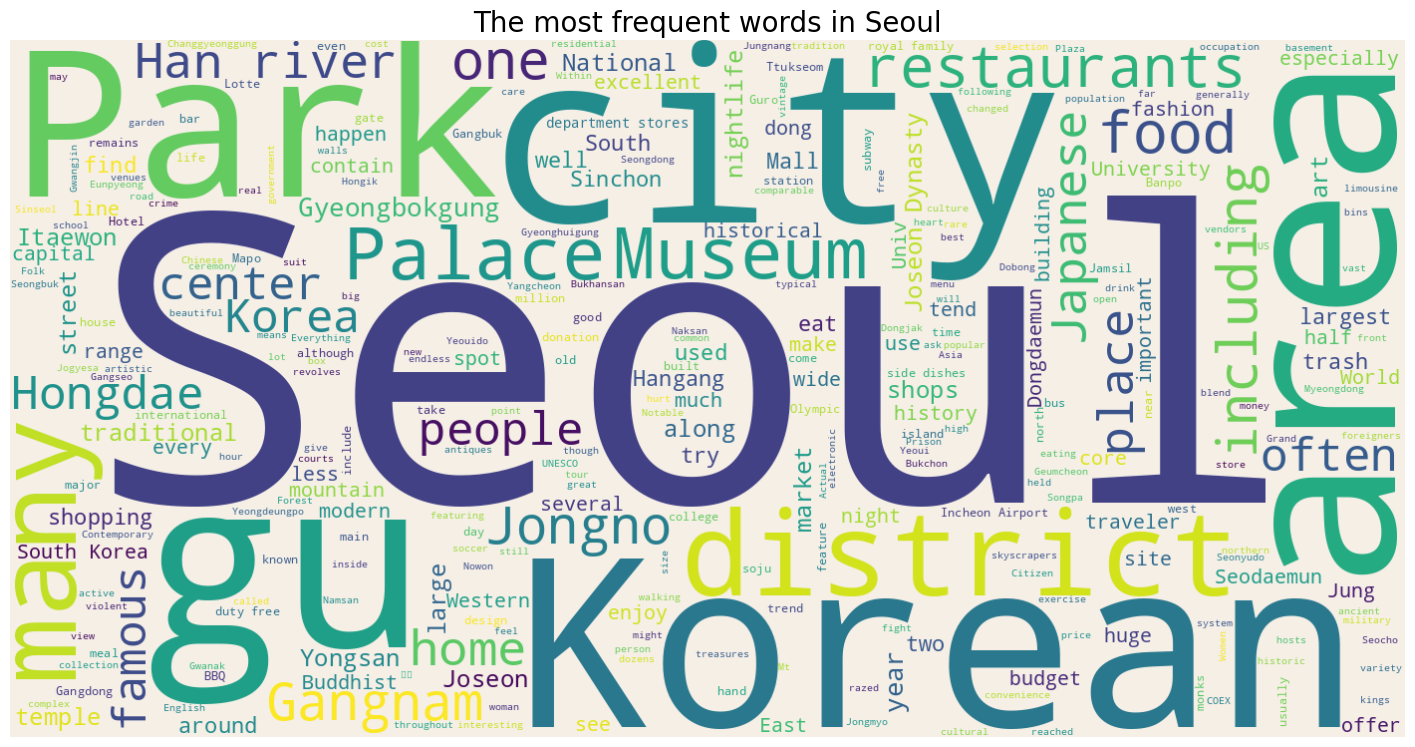

********************************************************************************************************************************************************************************************************


In [20]:
# create word clouds for text per each city 
for c in df["city"].unique():
    city_text = " ".join(df[df["city"] == c]["text"].astype(str))
    create_word_cloud(city_text, c)
